# Multidimensional Pattern identification with SAX
## In-site view

This script performs pattern identification over the {time, attribute} cuboid, that covers the intra-building frame. It serves for within-site exploration on how a given building operates across time and building-specific attributes.

The data is first normalized then transformed using SAX over normalized daily sequences. Motifs are identified across buildings, and a final clustering phase is executed over the reduced counts of sequences. 

Results are presented visually allowing interpretable analytics.

In [1]:
# Import modules
import pandas as pd
import numpy as np
import time
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
# SAX package - source https://github.com/seninp/saxpy
from saxpy.alphabet import cuts_for_asize
from saxpy.znorm import znorm
from saxpy.sax import ts_to_string
from saxpy.paa import paa
from sklearn.preprocessing import StandardScaler
# Plotting modules
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
plt.rcdefaults()
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.colors import n_colors
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

# Version
version = "v1.0"

# Path definition
path_data = "..\\data\\cube\\"
path_fig_out = "..\\figures\\insite_view\\"

## Read

In [2]:
def reduce_mem_usage(df, verbose=True):
    """"Function to reduce the memory usage of a dataframe.
    Source: https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction"""

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [13]:
# Read Cuboid
blg_id = "Bobcat_education_Alissa"
df = pd.read_csv(path_data + "cuboid_B_"+blg_id+".csv", index_col="timestamp")

# Format index to datetime object
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')

# Reduce memory usage
df = reduce_mem_usage(df, verbose=True)
df.head()

Mem. usage decreased to  0.33 Mb (64.3% reduction)


electricity     gas  hotwater  chilledwater  \
timestamp                                                          
2016-01-01 00:00:00      43.6875  3034.0    95.250           0.0   
2016-01-01 01:00:00      43.6875  3034.0    95.250           0.0   
2016-01-01 02:00:00      43.6875  3034.0    95.250           0.0   
2016-01-01 03:00:00      43.8750  3116.0    95.250           0.0   
2016-01-01 04:00:00      43.7500  3148.0   102.625           0.0   

                     airTemperature  seaLvlPressure  
timestamp                                            
2016-01-01 00:00:00      -14.398438          1037.0  
2016-01-01 01:00:00      -13.296875          1036.0  
2016-01-01 02:00:00      -15.000000          1036.0  
2016-01-01 03:00:00      -12.796875          1035.0  
2016-01-01 04:00:00      -14.398438          1035.0

## Pre-Mining transformation functions

In [4]:
from sklearn.preprocessing import MinMaxScaler
def scale_NanRobust(data_array, scaler):
    """ A function to scale an array while being robust to outliers.
    Adapted from: https://stackoverflow.com/questions/55280054/handling-missing-nan-values-on-sklearn-preprocessing"""
    # Set valid mask
    nan_mask = np.isnan(data_array)
    valid_mask = ~nan_mask
    # create a result array
    result = np.full(data_array.shape, np.nan)
    # assign only valid cases to
    result[valid_mask] = scaler.fit_transform(data_array[valid_mask].reshape(-1, 1)).reshape(data_array[valid_mask].shape)
    return result

def scale_df_columns_NanRobust(df_in, target_columns, scaler=MinMaxScaler(feature_range=(1, 2))):
    """"A function to normalize columns of a dataframe per column, while being robust to Nan values.
    The function returns a similar dataframe with missing values in identical places - normalized with the scaler object."""
    # Identify target from non-target column values
    nontarget_columns = list(set(df_in.columns) - set(target_columns))
    df = df_in[target_columns].copy()
    # Scale over the target columns
    array_scaled = []
    for col in df.columns:
        array_scaled.append(scale_NanRobust(df[col].values, scaler))
    df_scaled = pd.DataFrame(np.vstack(array_scaled).transpose(), columns=df.columns)
    # Set scaled dataframe index
    df_scaled[df_in.index.name] = df_in.index
    df_scaled.set_index([df_in.index.name], inplace=True, drop=True)
    # Merge non-target columns to the scaled frame
    df_scaled[nontarget_columns] = df_in[nontarget_columns]
    return df_scaled

## SAX functions

In [8]:
def SAX_mining(df_in, W=4, A=3):
    """"Function to perform daily SAX mining on input dataframe"""
    # Input definition of the function
    df_sax = df_in.copy()
    df_sax['Day'] = df_sax.index.dayofyear
    df_sax['Hour'] = df_sax.index.hour

    # Daily SAX over the year with reduced daily size
    sax_dict, counts, sax_data = dict(), dict(), dict()
    for meter in df_in.columns.values:
        # Daily heatmaps over all year
        sax_data[meter] = pd.pivot_table(df_sax, values=meter,
                                  index=['Day'], columns='Hour')
        sax_data[meter] = reduce_mem_usage(sax_data[meter], verbose=False)

        # Daily SAX obtained here with hourly resolution
        daily_sax = []
        for i in range(sax_data[meter].shape[0]):
            dat_paa = paa(sax_data[meter].values[i], W)
            daily_sax.append(ts_to_string(dat_paa, cuts_for_asize(A)))
        sax_dict[meter] = daily_sax

        # Now count the number of similar elements in the SAX list
        counts[meter] = Counter(sax_dict[meter])
    return sax_dict, counts, sax_data

def sax_count_reformat(sax_dict):
    """"Function to format SAX counts to a unified dataframe."""
    df_concat = [] #pd.DataFrame(columns=df_cub2.columns)
    for meter_data in sax_dict:
        counts[meter_data] = Counter(sax_dict[meter_data])
        # Create a dataframe from the counter object
        df_concat.append(pd.DataFrame.from_dict(counts[meter_data], orient='index', columns=[meter_data]))
    # Now concatenate the dictionary to one dataframe
    df_count = pd.concat(df_concat, axis=1)  # Reformated dataframe
    return df_count

def SAXcount_hm_wdendro(df_count, title):
    # Create Side Dendrogram
    # source: https://plotly.com/python/dendrogram/
    dendo = ff.create_dendrogram(df_count.values, orientation='left', labels=list(df_count.index.values))
    for i in range(len(dendo['data'])):
        dendo['data'][i]['xaxis'] = 'x2'
    # Create Heatmap
    dendro_leaves_txt = dendo['layout']['yaxis']['ticktext']
    # Convert the txt leaves to integer index values
    dendro_leaves = []
    for txt in df_count.index.values:
        dendro_leaves.append(list(dendro_leaves_txt).index(txt))
    dendro_leaves = list(map(int, dendro_leaves))

    heat_data = df_count.values[dendro_leaves, :]

    # Calling the subplots
    fig = go.Figure(data=go.Heatmap(z=heat_data,
                                    x=df_count.columns,
                                    y=df_count.index[dendro_leaves],
                                    # zmax=pzmax, zmin=pzmin,
                                    colorbar={"title": "Counts"},
                                    colorscale='Blues'))
    p_width = len(df_count.columns)*5 if len(df_count.columns)*5 > 400 else 400
    fig.update_layout(height=900, width=p_width,
                      xaxis={"tickmode": "array"},
                      title_text=f"SAX counts for attribute: {title}",
                      plot_bgcolor='#fff'
                      )
    fig.show()
    return fig

## Clustering functions

In [9]:
def elbow_wcss(X, n_cluster_max):
    """"Within Cluster Sum of Squares (WCSS) method for optimal number of clusters identification"""
    wcss, sil = [], []  # Within Cluster Sum of Squares (WCSS) & silhouette index
    for i in range(2, n_cluster_max):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans_pred_y = kmeans.fit_predict(X)
        wcss.append(kmeans.inertia_)  # WCSS
        sil.append(metrics.silhouette_score(X, kmeans_pred_y, metric="euclidean"))  # Silhouette score
    return wcss, sil

def similarity_index_plot(wcss, sil):
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs[0].scatter(range(2,len(sil)+2),sil,
                   c='c', marker='v')
    axs[1].scatter(range(2,len(wcss)+2),wcss,
                   c='r', marker='o')
    # Legend
    axs[0].set_ylabel('Silhouette')
    axs[1].set_ylabel('Cluster Sum of Squares')
    axs[1].set_xlabel('cluster number')
    # Set ticks inside
    plt.xticks(range(2,len(sil)+2), range(2,len(sil)+2))
    axs[0].tick_params(axis="y", direction="in", left="off", labelleft="on")
    axs[0].tick_params(axis="x", direction="in", left="off", labelleft="on")
    axs[1].tick_params(axis="x", direction="in", left="off", labelleft="on")
    axs[1].tick_params(axis="y", direction="in", left="off", labelleft="on")
    axs[0].grid(axis='y', color='grey', linestyle='--', linewidth=0.5, alpha=0.4)
    axs[1].grid(axis='y', color='grey', linestyle='--', linewidth=0.5, alpha=0.4)
    fig.tight_layout()
    plt.show()
    return fig

def cluster_counter_plot(counts, title=None):
    """Plot motif counts per cluster with whiskers"""
    stats = counts.describe()
    stats = stats.transpose().sort_values(by=['50%'], ascending=False).transpose()
    keys = counts.columns
    y_pos = np.arange(len(keys))
    yerr_pos = stats.loc['75%'].values - stats.loc['50%'].values
    yerr_neg = stats.loc['50%'].values - stats.loc['25%'].values
    # Now plotting
    fig = plt.figure(figsize=(6, 4))
    ax = plt.gca()
    plt.bar(y_pos,
             stats.loc['50%'].values,
             #yerr=stats.loc[['75%','25%']].values,          # Define error bar as the difference between 50% and quantiles
             yerr = [yerr_neg, yerr_pos],
             tick_label=keys,
             align='center',
             alpha=0.4)
    hfont = {'fontname': 'Times New Roman'}
    ax.tick_params(axis="y", direction="in", left="off", labelleft="on", labelsize=13)
    ax.tick_params(axis="x", direction="in", left="off", labelleft="on", labelsize=13)
    plt.xticks(y_pos, keys, rotation=90, **hfont)
    plt.yticks(**hfont)
    #plt.xlabel('Symbolic Aggregate Approximation sequences', **hfont)
    plt.ylabel('counts', fontsize=15, **hfont)
    plt.title(title, **hfont)
    plt.tight_layout()
    plt.show()
    return fig

## Motifs plotting functions

In [10]:
def counter_plot(counter, title=None):
    """Simple demo of a horizontal bar chart.
    Source: https://stackoverflow.com/questions/22222573/how-to-plot-counter-object-in-horizontal-bar-chart"""
    # Sort the counter dictionnary per value
    # source: https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    counter = {k: v for k, v in sorted(counter.items(), key=lambda item: item[1])}
    # Counter data, counter is your counter object
    keys = counter.keys()
    y_pos = np.arange(len(keys))
    # get the counts for each key, assuming the values are numerical
    performance = [counter[k] for k in keys]
    # Now plotting
    fig = plt.figure(figsize=(6, 6))
    plt.barh(y_pos, performance, align='center', alpha=0.4)
    plt.yticks(y_pos, keys)
    plt.xlabel('Number of profiles per symbolic sequence')
    plt.title(title)
    plt.show()
    return fig

def sax_df_reformat(sax_data, sax_dict, meter_data, space_btw_saxseq=3):
    """"Function to format a SAX timeseries original data for SAX heatmap plotting."""

    counts[meter_data] = Counter(sax_dict[meter_data])
    # Sort the counter dictionnary per value
    # source: https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    counter = {k: v for k, v in sorted(counts[meter_data].items(), key=lambda item: item[1])}
    keys = counter.keys()

    empty_sax_df = pd.DataFrame(columns=sax_data[meter_data].columns, index=[' ']*space_btw_saxseq)
    new_sax_df = pd.DataFrame(columns=sax_data[meter_data].columns)
    for sax_seq in keys:
        # Obtaining sax indexes of corresponding profiles within dataframe
        indexes = [i for i,x in enumerate(sax_dict[meter_data]) if x == sax_seq]   # returns all indexes
        # Formating a newdataframe from selected sax_seq
        df_block = sax_data[meter_data].iloc[indexes].copy()
        df_block["SAX"] = [sax_seq]*len(indexes)
        new_sax_df = pd.concat([df_block, empty_sax_df, new_sax_df], axis=0) # Reformated dataframe
    # Mapping the sax sequence to the data
    index_map_dictionary = dict()
    index_map_dictionary["SAX_seq"], index_map_dictionary["SAX_idx"] = [], []
    for sax_seq in keys:
        indexes = [i for i, x in enumerate(new_sax_df["SAX"]) if x == sax_seq]  # returns all indexes
        index_map_dictionary["SAX_seq"].append(sax_seq)
        index_map_dictionary["SAX_idx"].append(np.median(indexes))
    # Droping the SAX column of the dataframe now that we have a mapping variable for it
    new_sax_df.drop("SAX", axis=1, inplace=True)
    return new_sax_df, index_map_dictionary

def SAX_dailyhm_visualization(dict_numeric, sax_dict, index_map_dictionary, title):
    """"Function to visualize multi-attribute SAX sequences from original dataframe with SAX dictionary"""
    keys = list(sax_dict.keys())
    key_int = 0
    # First loop over all keys and data to identify min and max values of the time series
    for key in sax_dict:    # key can be meter_data or bld_id depending on the cuboid selected
        sax_seq_int = 0
        for sax_sequence_toidentify in sax_dict[key]:
            indexes = [i for i, x in enumerate(sax_dict[key]) if x == sax_sequence_toidentify]  # returns all indexes

            if key_int < 1:
                pzmax = dict_numeric[key].iloc[indexes].max().max()
                pzmin = dict_numeric[key].iloc[indexes].min().min()
            else:
                pzmax = max(pzmax, dict_numeric[key].iloc[indexes].max().max())
                pzmin = min(pzmin, dict_numeric[key].iloc[indexes].min().min())
            sax_seq_int = sax_seq_int + 1
        key_int = key_int + 1


    # Calling the subplots
    fig = make_subplots(rows=1, cols=len(keys), shared_yaxes=False, 
    horizontal_spacing=0.01+len(sax_dict[key][0])*0.005, column_titles=keys, x_title="Hour of the day")
    # Then Loop again of the set to plot
    key_int = 0
    # Looping over sax keys (i.e. attributes or blg keys)
    for key in sax_dict:
        # Plot
        fig.add_trace(go.Heatmap(z=dict_numeric[key],
                                 x=dict_numeric[key].columns,
                                 zmax=pzmax, zmin=pzmin,
                                 colorbar={"title": "Attribute normalized value"},
                                 colorscale='temps'),
                      row=1, col=key_int + 1)
        fig.update_yaxes(tickmode='array',
                         tickvals=index_map_dictionary[key]["SAX_idx"],
                         ticktext=index_map_dictionary[key]["SAX_seq"],
                         row=1, col=key_int+1)
        key_int = key_int + 1
    fig.update_layout(height=800, width=len(keys)*250,
                      xaxis={"tickmode": "array"},
                      title_text=f"Daily SAX profiles of {title}",
                      plot_bgcolor='#fff'
                      )
    fig.show()
    return fig

# Motifs identification

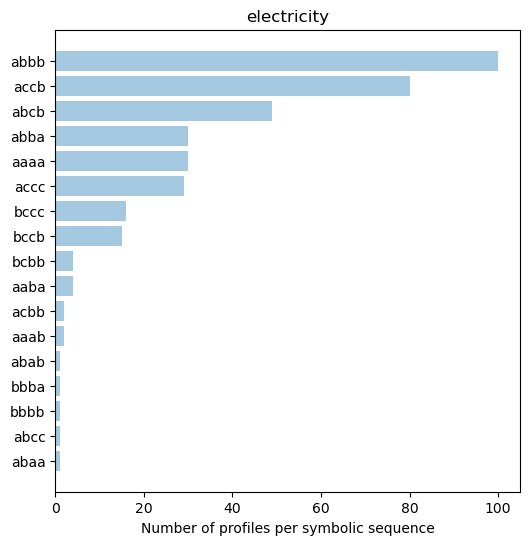

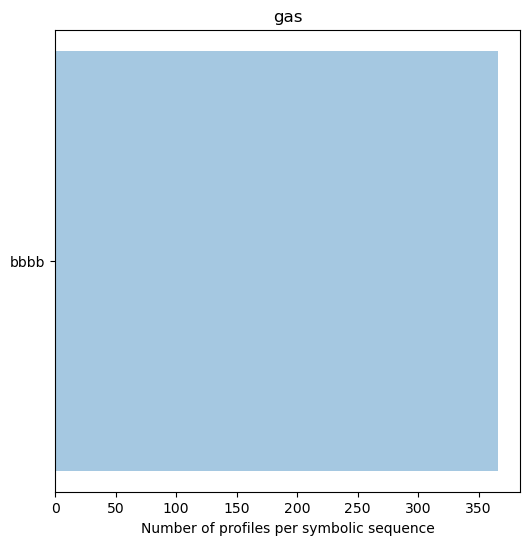

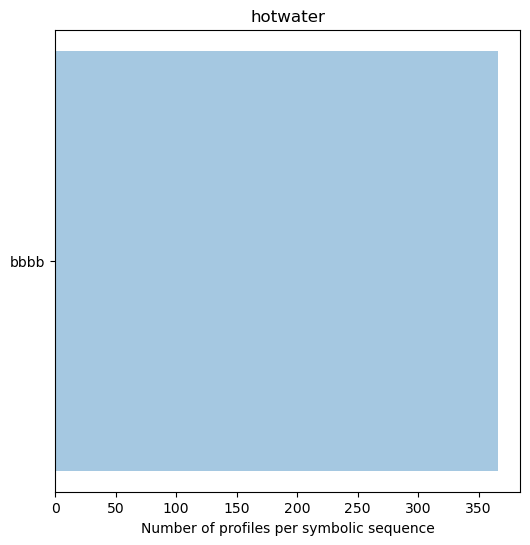

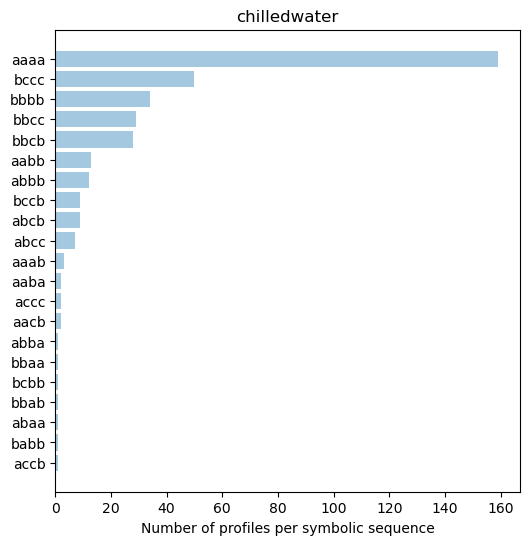

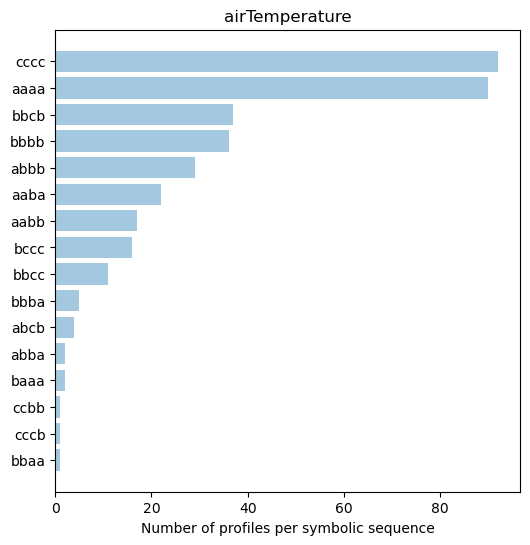

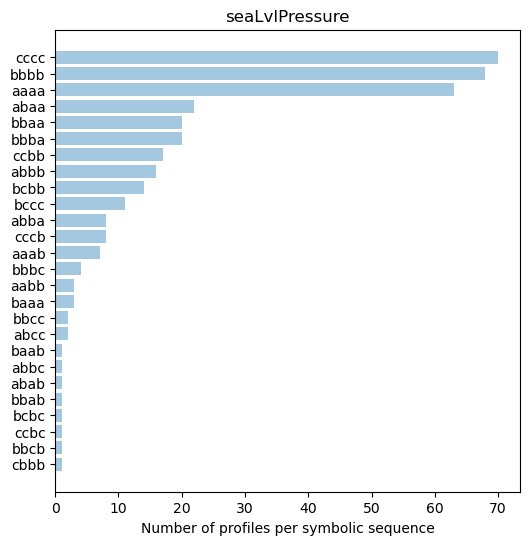

In [14]:
# SAX Parameters
day_number_of_pieces = 4
alphabet_size = 3
scaler_function = StandardScaler()

# Normalize per attribute
df_normalized = scale_df_columns_NanRobust(df, df.columns, scaler=scaler_function)

# Perform SAX transformation
sax_dict, counts, sax_data = SAX_mining(df_normalized, W=day_number_of_pieces, A=alphabet_size)

# Plot the sequence counts per attribute
for meter in df.columns.values:
    fig = counter_plot(counts[meter], title=meter)
    fig.savefig(path_fig_out+"SAXcounts_Attrib_StandardScaler_blg_"+blg_id+"_meter_"+meter+"_"+version+".jpg", dpi=300, bbox_inches='tight')

In [42]:
# Reformating sax results for plotting
sax_dict_data, index_map_dictionary = dict(), dict()
for meter in sax_data:
    sax_dict_data[meter], index_map_dictionary[meter] = sax_df_reformat(sax_data, sax_dict, meter)

# Plotting all SAX sequences and saving figure
fig = SAX_dailyhm_visualization(sax_dict_data, sax_dict, index_map_dictionary, blg_id)
fig.write_image(path_fig_out+"SAX_blg_"+blg_id+"_"+version+".png")

In [67]:
# Filter discords from established threshold
threshold = 10  # motif number threshold
indexes = dict()
for meter in df.columns.values:
    df_count = pd.DataFrame.from_dict(Counter(sax_dict[meter]), orient='index').rename(columns={0:'count'})
    df_count.fillna(0)
    motifs = df_count[(df_count > threshold)]
    indexes[meter] = [i for i,x in enumerate(sax_dict[meter]) if x in list(motifs.index)]  # returns all indexes

# ## WORKING HERE
# motifs_sax_data = dict()
# for meter in df.columns.values:
#     motifs_sax_data[meter] = sax_data[meter].iloc[indexes[meter]]

# # Reformating cluster results for plotting
# motifs_dict_data, motif_index_map_dictionary = dict(), dict()
# max_shape = 0
# for meter in sax_data:
#     motifs_dict_data[meter], motif_index_map_dictionary[meter] = sax_df_reformat(motifs_sax_data, sax_dict, meter)
#     max_shape = max(max_shape, max(np.shape(motifs_dict_data[meter])))
# # Adjusting reformaating from variable attribute motifs lengths
# for meter in motifs_sax_data:
#     # Defining width of empty dataframe to add
#     space_btw_saxseq = max_shape - max(np.shape(motifs_dict_data[meter]))
#     # Creating empty frame
#     empty_sax_df = pd.DataFrame(columns=motifs_sax_data[meter].columns, index=[' ']*space_btw_saxseq)
#     # Adding empty frame to the df
#     motifs_dict_data[meter] = motifs_dict_data[meter].append(empty_sax_df)

# # Plotting cluster results results
# fig = SAX_dailyhm_visualization(motifs_sax_data, motif_dict_data, motif_index_map_dictionary, title=blg_id)

## Attribute motifs clustering
Attribute daily profile motifs are clustered together resulting in a reduced number of typical patterns from the previous motif identification thanks to SAX trasnformation.

In [17]:
## Clustering identified motifs

# Cluster the identified motifs
nb_clusters_opt = 5
kmeans = KMeans(n_clusters=nb_clusters_opt, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_pred_y, clust_sax_data = dict(), dict()
for meter in df.columns.values:
    clust_sax_data[meter] = sax_data[meter].iloc[indexes[meter]]
    kmeans_pred_y[meter] = kmeans.fit_predict(clust_sax_data[meter].interpolate(method='linear'))

# Reformating cluster results for plotting
clust_dict_data, index_map_dictionary = dict(), dict()
max_shape = 0
for meter in sax_data:
    clust_dict_data[meter], index_map_dictionary[meter] = sax_df_reformat(clust_sax_data, kmeans_pred_y, meter)
    max_shape = max(max_shape, max(np.shape(clust_dict_data[meter])))
# Adjusting reformaating from variable attribute motifs lengths
for meter in sax_data:
    # Defining width of empty dataframe to add
    space_btw_saxseq = max_shape - max(np.shape(clust_dict_data[meter]))
    # Creating empty frame
    empty_sax_df = pd.DataFrame(columns=sax_data[meter].columns, index=[' ']*space_btw_saxseq)
    # Adding empty frame to the df
    clust_dict_data[meter] = clust_dict_data[meter].append(empty_sax_df)

# Plotting cluster results results
fig = SAX_dailyhm_visualization(clust_dict_data, sax_dict, index_map_dictionary, title=blg_id)
fig.write_image(path_fig_out+"clust_blg_"+blg_id+"_"+version+".png")